**Tunning dos hiperparâmetros**
- Será realizado o tunning para os seguintes casos:
    1) sem informações do WHOQOL na base
    2) com todas as respostas do WHOQOL
    3) só com o índice final do WHOQOL
    4) só com os índices dos domínios do WHOQOL

- Para os seguintes modelos:
    1) Random Forest
    2) SVM
    3) MLP
    4) XGBoost

**Workflow:**
Para cada caso:
1. Importar dados
2. Separar em treino, teste e validação.
3. Definir os parâmetros a serem testados
4. Realizar o tunning
5. Salvar os resultados graficamente
6. Salvar o melhor modelo
7. Aplicar o Random Under-Sampling no treino (Voltar para o passo 3).


## SETUP
(Executar apenas uma vez)

In [1]:
# Instalando bibliotecas
!pip install -U pandas
!pip install -U numpy
!pip install -U scipy
!pip install -U scikit-learn
!pip install -U imbalanced-learn
!pip install -U xgboost
!pip install -U mlxtend
!pip install -U joblib
!pip install -U seaborn
!pip install -U matplotlib


## Inicialização
(Executar sempre que reiniciar o kernel)

### Importando as bibliotecas

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, LabelEncoder, MinMaxScaler
import os
from sklearn.model_selection import KFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Importando modelo Dummy:
from sklearn.dummy import DummyClassifier
import pickle
import time
import multiprocessing
n_cpus = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings('ignore')

np.random.seed(13) # Para reproduzir os resultados

### Definindo a função

In [24]:
def perform_model_tuning(models, param_grids, base_name, data=None, target=None, x_train = None, y_train=None, x_test=None,  y_test=None):
    
    if data is not None and target is not None:
        # Dividir os dados em treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    elif x_train is not None and x_test is not None and y_train is not None and y_test is not None:
        X_train = x_train
        X_test = x_test
        y_train = y_train
        y_test = y_test
    else:
        raise ValueError("Parâmetros inválidos. É necessário passar os dados e os rótulos ou os conjuntos de treino e teste.")

    start_tunning = time.time()
    
    best_models = {}  # Dicionário para armazenar o melhor modelo de cada tipo
    model_accuracies = {}  # Dicionário para armazenar as acurácias de cada modelo
    current_dir = os.getcwd()
    for model_name, model, param_grid_entry in zip(models.keys(), models.values(), param_grids):
        print(f"Tuning do modelo {model_name} iniciado...")

        # Acessar o dicionário de parâmetros correspondente ao modelo atual
        param_grid = param_grid_entry['params']

        # Realizar a busca em grid para encontrar os melhores parâmetros
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
        
        # Iniciar a contagem do tempo
        start = time.time()
        
        grid_search.fit(X_train, y_train)
        
        # Finalizar a contagem do tempo
        end = time.time()
        print(f"Tempo de execução: {end - start:.2f}s | Modelo: {model_name}")
        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_

        # Fazer previsões no conjunto de teste
        y_pred = best_model.predict(X_test)

        # Calcular a acurácia do modelo
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracies[model_name] = accuracy

        print(f"Acurácia do modelo {model_name}: {accuracy:.4f}")

        # Salvar o melhor modelo
        best_models[model_name] = best_model

    # Plotar gráfico de desempenho comparativo
    plt.figure(figsize=(10, 6))
    plt.bar(model_accuracies.keys(), model_accuracies.values())
    plt.xlabel('Modelos')
    plt.ylabel('Acurácia')
    plt.title('Comparação de desempenho dos modelos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    graph_filename = f"{base_name}_graph.png"
    graph_path = os.path.join(current_dir, graph_filename)
    plt.savefig(graph_path)
    plt.close()

    end_tunning = time.time()

    #Pickle the single best model, verifying the best and saving from best_models dict, se tiver mais algo salvo com o mesmo nome, adiciona mais um.
    best_model = max(model_accuracies, key=model_accuracies.get)
    print(f"\n\nMelhor modelo: {best_model} | Acurácia: {model_accuracies[best_model]}")
    print(f"\nTempo de execução total :{end - start:.2f}s")
    best_model = best_models[best_model]
    if os.path.exists(f"{base_name}_{best_model}_best_model.pkl"):
        i = 1
        while os.path.exists(f"{base_name}_{best_model}_best_model_{i}.pkl"):
            i += 1
        pickle.dump(best_model, open(f"{base_name}_{best_model}_best_model_{i}.pkl", "wb"))
    else:
        pickle.dump(best_model, open(f"{base_name}_{best_model}_best_model.pkl", "wb"))
    # Salvar tabela com os valores de acurácia
    table_filename = f"{base_name}_acuracy.csv"
    accuracies_df = pd.DataFrame.from_dict(model_accuracies, orient='index', columns=['Acurácia'])
    table_path = os.path.join(current_dir, table_filename)
    accuracies_df.to_csv(table_path, index=False)

    return best_models

In [25]:
def avalia_modelo_cv(model, X_input, y_input, n, resultados_individuais=False):
    kf = KFold(n_splits=n)
    reports = []
    y_true = []
    y_pred_list = []
    X_array = X_input.values
    accuracy_list = []
    model_name = type(model).__name__
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X_input)):
        X_input, X_test = X_array[train_index], X_array[test_index]
        y_train, y_test = y_input[train_index], y_input[test_index]
        model.fit(X_input, y_train)
        y_pred = model.predict(X_test)
        y_true.extend(y_test)
        y_pred_list.append(y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)
        reports.append(report)
        accuracy_list.append(accuracy_score(y_test, y_pred))
        if resultados_individuais:
            print(f"Classification Report for fold {fold_idx + 1}:\n{report}\n")
    y_pred_total = np.concatenate(y_pred_list)
    print("-" * 45)
    print("model_name: ", model_name)
    print("Average Classification Report:")
    avg_report = classification_report(y_true, y_pred_total, zero_division=0)
    print(avg_report)
    #Retorna a acuracia media
    return accuracy_score(y_true, y_pred_total)


# Função que chama os 4 modelos e retorna o resultado de cada um usando a função avalia_modelo_cv e imprime o resultado de cada um.

def avalia_dif_modelos_cv(X_train, y_test, cv):
    # Criando os modelos
    dummy_av = DummyClassifier(strategy='most_frequent', random_state=13)
    rf_av = RandomForestClassifier(n_jobs=n_cpus, random_state=13)
    svm_av = SVC(kernel='rbf', gamma='auto', decision_function_shape='ovo', random_state=13)
    mlp_av = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=13)
    xgb_av = XGBClassifier(n_jobs=n_cpus, random_state=13)
    knn_av = KNeighborsClassifier(n_jobs=n_cpus)
    ada_av = AdaBoostClassifier(random_state=13)
    nvb_av = GaussianNB()
    lr_av = LogisticRegression(random_state=13)
    dt_av = DecisionTreeClassifier(random_state=13)
    

    # Aplicando a função de avaliação
    dummy_fun_av = avalia_modelo_cv(dummy_av, X_train, y_test, cv)
    rf_fun_av = avalia_modelo_cv(rf_av, X_train, y_test, cv)
    svm_fun_av = avalia_modelo_cv(svm_av, X_train, y_test, cv)
    mlp_fun_av = avalia_modelo_cv(mlp_av, X_train, y_test, cv)
    xgb_fun_av = avalia_modelo_cv(xgb_av, X_train, y_test, cv)
    knn_fun_av = avalia_modelo_cv(knn_av, X_train, y_test, cv)
    ada_fun_av = avalia_modelo_cv(ada_av, X_train, y_test, cv)
    nvb_fun_av = avalia_modelo_cv(nvb_av, X_train, y_test, cv)
    lr_fun_av = avalia_modelo_cv(lr_av, X_train, y_test, cv)
    dt_fun_av = avalia_modelo_cv(dt_av, X_train, y_test, cv)
    

    # Criando o dataframe com os resultados
    df_resultado = pd.DataFrame({'Modelo': ['Dummy', 'RF', 'SVM', 'MLP', 'XGB', 'KNN', 'ADA', 'NVB', 'LR', 'DT'],
                                 'Acurácia': [dummy_fun_av, rf_fun_av, svm_fun_av, mlp_fun_av, xgb_fun_av, knn_fun_av, ada_fun_av, nvb_fun_av, lr_fun_av, dt_fun_av]})


    # Ordenando o dataframe pela acurácia
    df_resultado = df_resultado.sort_values(by='Acurácia', ascending=False)

    # Define a color dictionary for each model
    model_colors = {
        'Dummy': 'gray',
        'RF': 'blue',
        'SVM': 'green',
        'MLP': 'orange',
        'XGB': 'purple',
        'KNN': 'brown',
        'ADA': 'pink',
        'NVB': 'red',
        'LR': 'cyan',
        'DT': 'olive'
    }

    # Plotando o gráfico de barras, que vai de 0 a 1
    ax = sns.barplot(y='Modelo', x='Acurácia', data=df_resultado, palette=[model_colors[model] for model in df_resultado['Modelo']])
    plt.xlim(0, 1)

    # Adicionando os valores nas barras
    for index, value in enumerate(df_resultado['Acurácia']):
        ax.text(value + 0.01, index, f'{value:.4f}', va='center', fontsize=8, color='black')

    plt.show("Desempenho dos modelos")
    #%matplotlib inline

    return df_resultado

In [26]:
def perform_cross_validation(model, X, y, cv, verbose=True):
    reports = []
    predictions = cross_val_predict(model, X, y, cv=cv)

    for fold in range(cv):
        start = fold * len(X) // cv
        end = (fold + 1) * len(X) // cv
        report = classification_report(y[start:end], predictions[start:end], output_dict=True)
        reports.append(report)

        if verbose:
            print(f"Fold {fold + 1} Classification Report:")
            print(classification_report(y[start:end], predictions[start:end]))
            print("-" * 50)

    avg_report = {
        'precision': np.mean([report['weighted avg']['precision'] for report in reports]),
        'recall': np.mean([report['weighted avg']['recall'] for report in reports]),
        'f1-score': np.mean([report['weighted avg']['f1-score'] for report in reports]),
        'support': np.mean([report['weighted avg']['support'] for report in reports])
    }

    accuracy = accuracy_score(y, predictions)

    if verbose or not verbose:
        print("Average Classification Report:")
        print(classification_report(y, predictions))
        print("-" * 50)
        print(f"Accuracy: {accuracy:.2f}")

    return None


In [27]:
# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='accuracy',
                  cv=cv,
                  n_jobs=n_cpus)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

In [28]:
def updt_maxfeature(modelo):
    try:
        if modelo.get_params()['max_features'] == 'auto':
            modelo.max_features = 'sqrt'
            print(modelo)
    except:
        pass


### Importando os dados

In [30]:
# Sem WHOQOL:
base1 = pd.read_csv('Datasets/dataframe_socioeconomico_Niveis.csv')
data1 = base1.drop('Nivel_MHI', axis=1)
target1 = base1['Nivel_MHI']
le = LabelEncoder()
target1 = le.fit_transform(target1)

# Dividir os dados em treino e teste
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1, target1, test_size=0.2, random_state=13)

# Aplicando non_linear scaler e converter para dataframe
scaler_data1 = MinMaxScaler()
X_train1 = scaler_data1.fit_transform(X_train1)
X_test1 = scaler_data1.transform(X_test1)
X_train1 = pd.DataFrame(X_train1, columns=data1.columns)
X_test1 = pd.DataFrame(X_test1, columns=data1.columns)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train1_re, y_train1_re = sampler.fit_resample(X_train1, y_train1)

# Divide em train_re e val_re
X_train1_re, X_val1_re, y_train1_re, y_val1_re = train_test_split(X_train1_re, y_train1_re, test_size=0.2, random_state=13)


In [31]:
# Com todas as respostas do WHOQOL
base2 = pd.read_csv('Datasets/df_social_whoqol_tratado_1.csv')
data2 = base2.drop('Nivel_MHI', axis=1)
target2 = base2['Nivel_MHI']
target2 = le.fit_transform(target2)

# Dividir os dados em treino e teste
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=13)

# Aplicando MaxAbsScaler
scaler_data2 = StandardScaler()
X_train2 = scaler_data2.fit_transform(X_train2)
X_test2 = scaler_data2.transform(X_test2)
X_train2 = pd.DataFrame(X_train2, columns=data2.columns)
X_test2 = pd.DataFrame(X_test2, columns=data2.columns)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train2_re, y_train2_re = sampler.fit_resample(X_train2, y_train2)

# Divide em train_re e val_re
X_train2_re, X_val2_re, y_train2_re, y_val2_re = train_test_split(X_train2_re, y_train2_re, test_size=0.2, random_state=13)


In [32]:
# Só com o indice dos dominiosdo WHOQOL, concatenar base1 com final da base2
data3 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']]], axis=1)
target3 = base2['Nivel_MHI']
target3 = le.fit_transform(target3)

# Dividir os dados em treino e teste
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.2, random_state=13)

# Aplicando MaxAbsScaler
scaler_data3 = StandardScaler()
X_train3 = scaler_data3.fit_transform(X_train3)
X_test3 = scaler_data3.transform(X_test3)
X_train3 = pd.DataFrame(X_train3, columns=data3.columns)
X_test3 = pd.DataFrame(X_test3, columns=data3.columns)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)
X_train3_re, y_train3_re = sampler.fit_resample(X_train3, y_train3)

# Divide em train_re e val_re
X_train3_re, X_val3_re, y_train3_re, y_val3_re = train_test_split(X_train3_re, y_train3_re, test_size=0.2, random_state=13)

In [47]:
# Só com a qualidade de vida do WHOQOL
data4 = pd.concat([data1, base2['BR']], axis=1)
target4 = base2['Nivel_MHI']
target4 = le.fit_transform(target4)

# Dividir os dados em treino e teste
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4, target4, test_size=0.2, random_state=13)

# Aplicando MaxAbsScaler
scaler_data4 = StandardScaler()
X_train4 = scaler_data4.fit_transform(X_train4)
X_test4 = scaler_data4.transform(X_test4)
X_train4 = pd.DataFrame(X_train4, columns=data4.columns)
X_test4 = pd.DataFrame(X_test4, columns=data4.columns)

sampler = RandomUnderSampler(random_state=13)
X_train4_re, y_train4_re = sampler.fit_resample(X_train4, y_train4)

# Divide em train_re e val_re
X_train4_re, X_val4_re, y_train4_re, y_val4_re = train_test_split(X_train4_re, y_train4_re, test_size=0.2, random_state=13)

In [67]:
# Qualidade de Vida Geral ( Media das duas primeiras questões do WHOQOL)
# Pegar a média das duas primeiras colunas da base2, pelo indice
data5 = pd.concat([data1, base2.loc[:,['BR','BS']].mean(axis=1)], axis=1)
target5 = base2['Nivel_MHI']
target5 = le.fit_transform(target5)

#Remover strings das colunas
data5.columns = data5.columns.astype(str)

# Dividir os dados em treino e teste
X_train5, X_test5, y_train5, y_test5 = train_test_split(data5, target5, test_size=0.2, random_state=13)

# Aplicando MaxAbsScaler
scaler_data5 = StandardScaler()
X_train5 = scaler_data5.fit_transform(X_train5)
X_test5 = scaler_data5.transform(X_test5)

X_train5 = pd.DataFrame(X_train5, columns=data5.columns)
X_test5 = pd.DataFrame(X_test5, columns=data5.columns)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)

X_train5_re, y_train5_re = sampler.fit_resample(X_train5, y_train5)

# Divide em train_re e val_re
X_train5_re, X_val5_re, y_train5_re, y_val5_re = train_test_split(X_train5_re, y_train5_re, test_size=0.2, random_state=13)

In [68]:
# Media de todos os dominios do WHOQOL
data6 = pd.concat([data1, base2.loc[:,['CR','CS','CT','CU']].mean(axis=1)], axis=1)
target6 = base2['Nivel_MHI']
target6 = le.fit_transform(target6)

data6.columns = data6.columns.astype(str)

# Dividir os dados em treino e teste
X_train6, X_test6, y_train6, y_test6 = train_test_split(data6, target6, test_size=0.2, random_state=13)

# Aplicando MaxAbsScaler
scaler_data6 = StandardScaler()
X_train6 = scaler_data6.fit_transform(X_train6)
X_test6 = scaler_data6.transform(X_test6)
X_train6 = pd.DataFrame(X_train6, columns=data6.columns)
X_test6 = pd.DataFrame(X_test6, columns=data6.columns)

# Realizar Random Under-Sampling no treino
sampler = RandomUnderSampler(random_state=13)

# Como string
X_train6.columns = X_train6.columns.astype(str)

X_train6_re, y_train6_re = sampler.fit_resample(X_train6, y_train6)

# Divide em train_re e val_re
X_train6_re, X_val6_re, y_train6_re, y_val6_re = train_test_split(X_train6_re, y_train6_re, test_size=0.2, random_state=13)

## Analise exploratória dos dados
- Ver numero de linhas e colunas de cada base, com e sem Random Under-Sampling. 
- Ver como ficou divisão de treino e teste.
- Ver como ficou a divisão de treino e validação.
- Ver como ficou a divisão de treino e teste com o Random Under-Sampling.

### Verificando o tamanho das bases

In [69]:
# Verificando o tamanho das bases 
print("Tamanho das bases:")
print(f"Base 1: {data1.shape}")
print(f"Base 2: {data2.shape}")
print(f"Base 3: {data3.shape}")
print(f"Base 4: {data4.shape}")
print(f"Base 5: {data5.shape}")
print(f"Base 6: {data6.shape}")


Tamanho das bases:
Base 1: (872, 54)
Base 2: (872, 84)
Base 3: (872, 58)
Base 4: (872, 55)
Base 5: (872, 55)
Base 6: (872, 55)


In [70]:
# Verificando o tamanho das bases de treino e teste
print("Tamanho das bases de treino e teste:")
print(f"Base 1: {X_train1.shape}, {X_test1.shape}")
print(f"Base 2: {X_train2.shape}, {X_test2.shape}")
print(f"Base 3: {X_train3.shape}, {X_test3.shape}")
print(f"Base 4: {X_train4.shape}, {X_test4.shape}")
print(f"Base 5: {X_train5.shape}, {X_test5.shape}")
print(f"Base 6: {X_train6.shape}, {X_test6.shape}")

Tamanho das bases de treino e teste:
Base 1: (697, 54), (175, 54)
Base 2: (697, 84), (175, 84)
Base 3: (697, 58), (175, 58)
Base 4: (697, 55), (175, 55)
Base 5: (697, 55), (175, 55)
Base 6: (697, 55), (175, 55)


In [71]:
# Verificando o tamanho das bases com Random Under-Sampling
print("Tamanho das bases com Random Under-Sampling:")
print(f"Base 1: Treino {X_train1_re.shape} {y_train1_re.shape} | Teste: {X_test1.shape} {y_test1.shape}")
print(f"Base 2: Treino {X_train2_re.shape} {y_train2_re.shape} | Teste: {X_test2.shape} {y_test2.shape}")
print(f"Base 3: Treino {X_train3_re.shape} {y_train3_re.shape} | Teste: {X_test3.shape} {y_test3.shape}")
print(f"Base 4: Treino {X_train4_re.shape} {y_train4_re.shape} | Teste: {X_test4.shape} {y_test4.shape}")
print(f"Base 5: Treino {X_train5_re.shape} {y_train5_re.shape} | Teste: {X_test5.shape} {y_test5.shape}")
print(f"Base 6: Treino {X_train6_re.shape} {y_train6_re.shape} | Teste: {X_test6.shape} {y_test6.shape}")

Tamanho das bases com Random Under-Sampling:
Base 1: Treino (285, 54) (285,) | Teste: (175, 54) (175,)
Base 2: Treino (285, 84) (285,) | Teste: (175, 84) (175,)
Base 3: Treino (285, 58) (285,) | Teste: (175, 58) (175,)
Base 4: Treino (285, 55) (285,) | Teste: (175, 55) (175,)
Base 5: Treino (285, 55) (285,) | Teste: (175, 55) (175,)
Base 6: Treino (285, 55) (285,) | Teste: (175, 55) (175,)


### Verificando a distribuição das classes

In [72]:
# Verificando a distribuição das classes
print("Distribuição das classes:")
print(f"Base 1: {np.unique(target1, return_counts=True)}")
print(f"Base 2: {np.unique(target2, return_counts=True)}")
print(f"Base 3: {np.unique(target3, return_counts=True)}")
print(f"Base 4: {np.unique(target4, return_counts=True)}")
print(f"Base 5: {np.unique(target5, return_counts=True)}")
print(f"Base 6: {np.unique(target6, return_counts=True)}")

Distribuição das classes:
Base 1: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 2: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 3: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 4: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 5: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))
Base 6: (array([0, 1, 2]), array([149, 149, 574], dtype=int64))


In [73]:
# Verificando a distribuição das classes com Random Under-Sampling
print("Distribuição das classes com Random Under-Sampling:")
print(f"Base 1: {np.unique(y_train1_re, return_counts=True)}")
print(f"Base 2: {np.unique(y_train2_re, return_counts=True)}")
print(f"Base 3: {np.unique(y_train3_re, return_counts=True)}")
print(f"Base 4: {np.unique(y_train4_re, return_counts=True)}")
print(f"Base 5: {np.unique(y_train5_re, return_counts=True)}")
print(f"Base 6: {np.unique(y_train6_re, return_counts=True)}")

Distribuição das classes com Random Under-Sampling:
Base 1: (array([0, 1, 2]), array([92, 96, 97], dtype=int64))
Base 2: (array([0, 1, 2]), array([92, 96, 97], dtype=int64))
Base 3: (array([0, 1, 2]), array([92, 96, 97], dtype=int64))
Base 4: (array([0, 1, 2]), array([92, 96, 97], dtype=int64))
Base 5: (array([0, 1, 2]), array([92, 96, 97], dtype=int64))
Base 6: (array([0, 1, 2]), array([92, 96, 97], dtype=int64))


## Avaliando modelos sem Under-Sampling

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.05      0.09       119
           1       0.44      0.06      0.10       119
           2       0.67      0.97      0.79       459

    accuracy                           0.66       697
   macro avg       0.53      0.36      0.33       697
weighted avg       0.60      0.66      0.55       697

--------------------

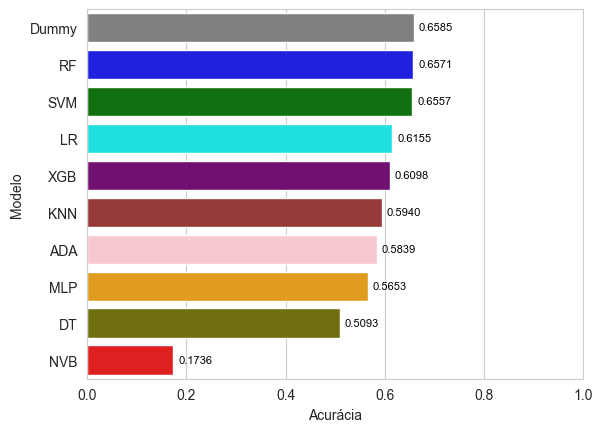

,Modelo,Acurácia
0,Dummy,0.658537
1,RF,0.657102
2,SVM,0.655667
8,LR,0.615495
4,XGB,0.609756
5,KNN,0.593974
6,ADA,0.583931
3,MLP,0.565280
9,DT,0.509326
7,NVB,0.173601


In [74]:
avalia_dif_modelos_cv(X_train1, y_train1, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.39      0.51       119
           1       0.79      0.58      0.67       119
           2       0.78      0.92      0.84       459

    accuracy                           0.77       697
   macro avg       0.76      0.63      0.67       697
weighted avg       0.77      0.77      0.75       697

--------------------

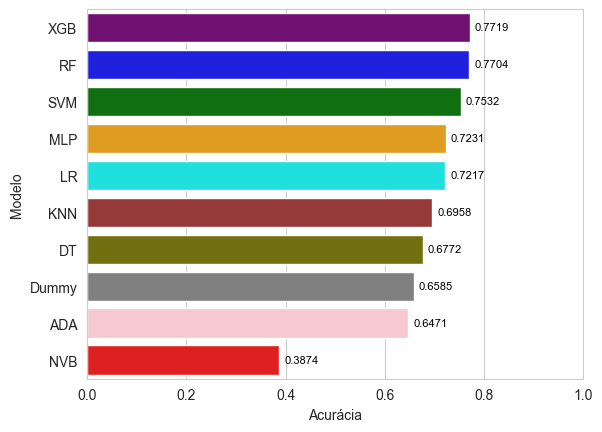

,Modelo,Acurácia
4,XGB,0.771879
1,RF,0.770445
2,SVM,0.753228
3,MLP,0.723099
8,LR,0.721664
5,KNN,0.695839
9,DT,0.677188
0,Dummy,0.658537
6,ADA,0.647059
7,NVB,0.387374


In [75]:
avalia_dif_modelos_cv(X_train2, y_train2, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.38      0.49       119
           1       0.84      0.50      0.62       119
           2       0.76      0.93      0.84       459

    accuracy                           0.76       697
   macro avg       0.77      0.60      0.65       697
weighted avg       0.77      0.76      0.74       697

--------------------

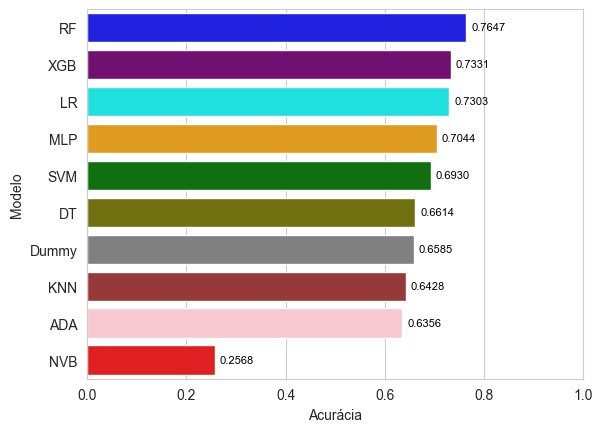

,Modelo,Acurácia
1,RF,0.764706
4,XGB,0.733142
8,LR,0.730273
3,MLP,0.704448
2,SVM,0.692970
9,DT,0.661406
0,Dummy,0.658537
5,KNN,0.642755
6,ADA,0.635581
7,NVB,0.256815


In [76]:
avalia_dif_modelos_cv(X_train3, y_train3, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.08      0.14       119
           1       0.56      0.15      0.24       119
           2       0.68      0.96      0.79       459

    accuracy                           0.67       697
   macro avg       0.63      0.40      0.39       697
weighted avg       0.65      0.67      0.59       697

--------------------

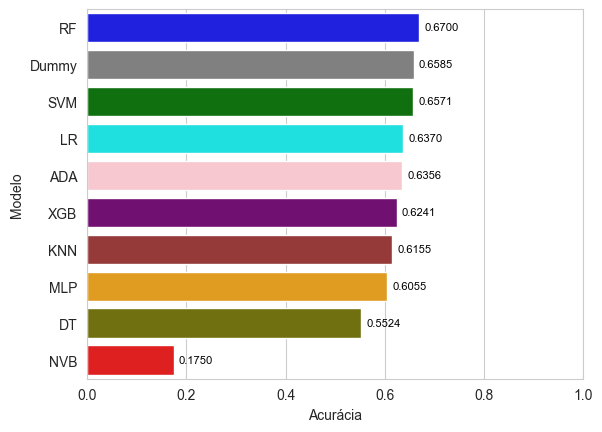

,Modelo,Acurácia
1,RF,0.670014
0,Dummy,0.658537
2,SVM,0.657102
8,LR,0.637016
6,ADA,0.635581
4,XGB,0.624103
5,KNN,0.615495
3,MLP,0.605452
9,DT,0.552367
7,NVB,0.175036


In [77]:
avalia_dif_modelos_cv(X_train4, y_train4, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.09      0.16       119
           1       0.53      0.14      0.23       119
           2       0.67      0.95      0.79       459

    accuracy                           0.66       697
   macro avg       0.59      0.39      0.39       697
weighted avg       0.63      0.66      0.58       697

--------------------

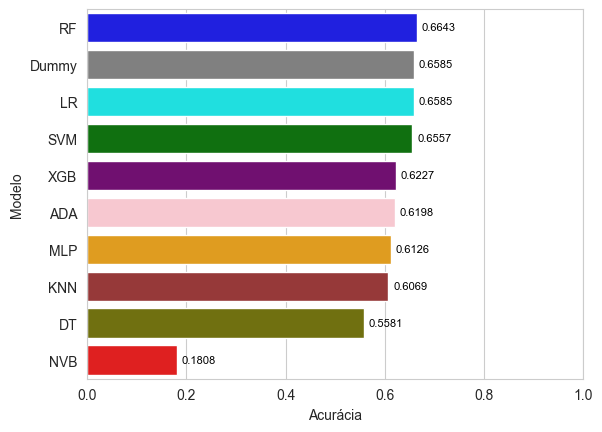

,Modelo,Acurácia
1,RF,0.664275
0,Dummy,0.658537
8,LR,0.658537
2,SVM,0.655667
4,XGB,0.622669
6,ADA,0.619799
3,MLP,0.612626
5,KNN,0.606887
9,DT,0.558106
7,NVB,0.180775


In [78]:
avalia_dif_modelos_cv(X_train5, y_train5, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.00      0.00      0.00       119
           2       0.66      1.00      0.79       459

    accuracy                           0.66       697
   macro avg       0.22      0.33      0.26       697
weighted avg       0.43      0.66      0.52       697
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.24      0.37       119
           1       0.72      0.26      0.38       119
           2       0.71      0.95      0.81       459

    accuracy                           0.71       697
   macro avg       0.73      0.49      0.52       697
weighted avg       0.72      0.71      0.66       697

--------------------

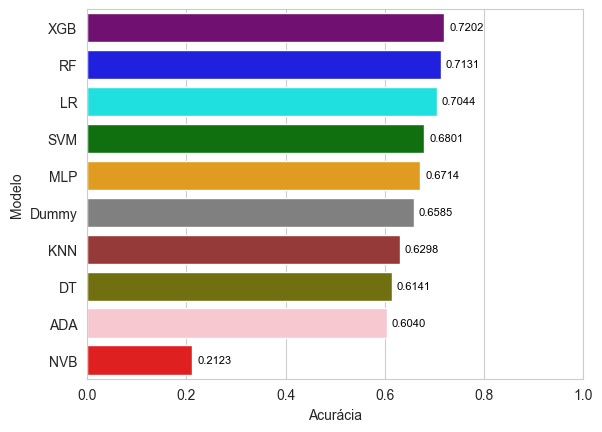

,Modelo,Acurácia
4,XGB,0.720230
1,RF,0.713056
8,LR,0.704448
2,SVM,0.680057
3,MLP,0.671449
0,Dummy,0.658537
5,KNN,0.629842
9,DT,0.614060
6,ADA,0.604017
7,NVB,0.212339


In [79]:
avalia_dif_modelos_cv(X_train6, y_train6, 5)

## Avaliando modelos com Under-Sampling

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        92
           1       0.25      0.15      0.18        96
           2       0.29      0.34      0.31        97

    accuracy                           0.25       285
   macro avg       0.25      0.25      0.25       285
weighted avg       0.25      0.25      0.25       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.50        92
           1       0.55      0.58      0.57        96
           2       0.39      0.36      0.37        97

    accuracy                           0.48       285
   macro avg       0.48      0.48      0.48       285
weighted avg       0.48      0.48      0.48       285

--------------------

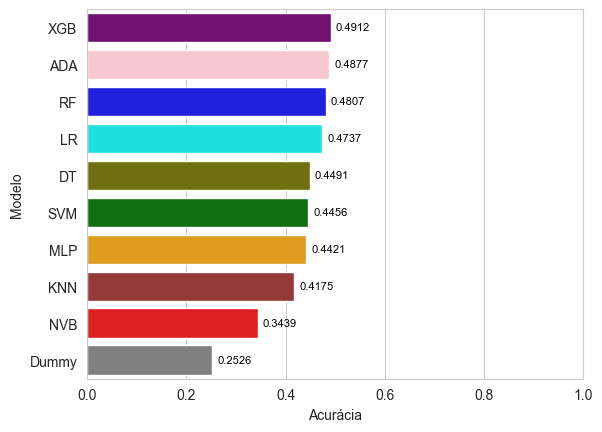

,Modelo,Acurácia
4,XGB,0.491228
6,ADA,0.487719
1,RF,0.480702
8,LR,0.473684
9,DT,0.449123
2,SVM,0.445614
3,MLP,0.442105
5,KNN,0.417544
7,NVB,0.343860
0,Dummy,0.252632


In [80]:
# Avaliando os modelos para cada dado com o treino
avalia_dif_modelos_cv(X_train1_re, y_train1_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        92
           1       0.25      0.15      0.18        96
           2       0.29      0.34      0.31        97

    accuracy                           0.25       285
   macro avg       0.25      0.25      0.25       285
weighted avg       0.25      0.25      0.25       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        92
           1       0.82      0.86      0.84        96
           2       0.59      0.56      0.57        97

    accuracy                           0.72       285
   macro avg       0.71      0.72      0.71       285
weighted avg       0.71      0.72      0.71       285

--------------------

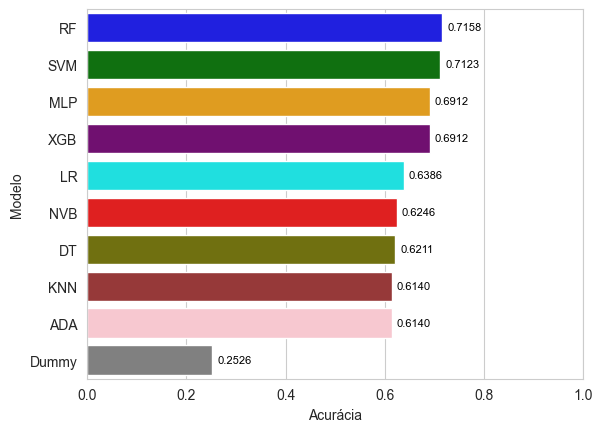

,Modelo,Acurácia
1,RF,0.715789
2,SVM,0.712281
3,MLP,0.691228
4,XGB,0.691228
8,LR,0.638596
7,NVB,0.624561
9,DT,0.621053
5,KNN,0.614035
6,ADA,0.614035
0,Dummy,0.252632


In [81]:
avalia_dif_modelos_cv(X_train2_re, y_train2_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        92
           1       0.25      0.15      0.18        96
           2       0.29      0.34      0.31        97

    accuracy                           0.25       285
   macro avg       0.25      0.25      0.25       285
weighted avg       0.25      0.25      0.25       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        92
           1       0.79      0.88      0.83        96
           2       0.55      0.44      0.49        97

    accuracy                           0.68       285
   macro avg       0.67      0.69      0.68       285
weighted avg       0.67      0.68      0.67       285

--------------------

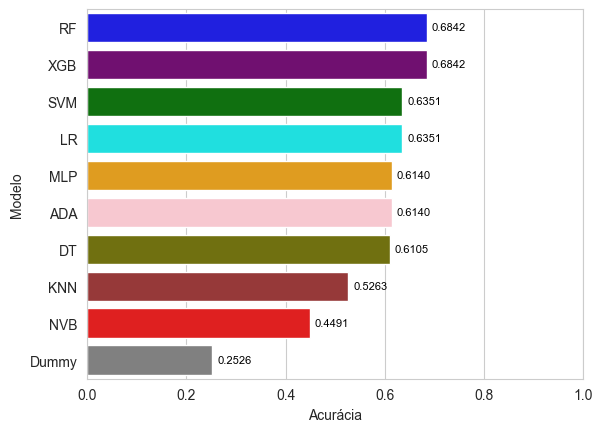

,Modelo,Acurácia
1,RF,0.684211
4,XGB,0.684211
2,SVM,0.635088
8,LR,0.635088
3,MLP,0.614035
6,ADA,0.614035
9,DT,0.610526
5,KNN,0.526316
7,NVB,0.449123
0,Dummy,0.252632


In [82]:
avalia_dif_modelos_cv(X_train3_re, y_train3_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        92
           1       0.25      0.15      0.18        96
           2       0.29      0.34      0.31        97

    accuracy                           0.25       285
   macro avg       0.25      0.25      0.25       285
weighted avg       0.25      0.25      0.25       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        92
           1       0.64      0.70      0.67        96
           2       0.41      0.33      0.37        97

    accuracy                           0.56       285
   macro avg       0.55      0.57      0.56       285
weighted avg       0.55      0.56      0.56       285

--------------------

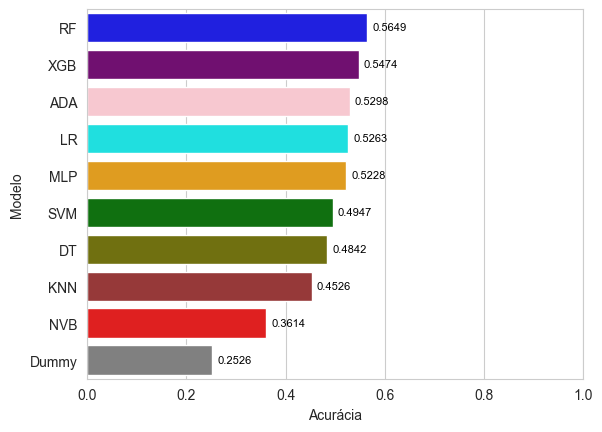

,Modelo,Acurácia
1,RF,0.564912
4,XGB,0.547368
6,ADA,0.529825
8,LR,0.526316
3,MLP,0.522807
2,SVM,0.494737
9,DT,0.484211
5,KNN,0.452632
7,NVB,0.361404
0,Dummy,0.252632


In [83]:
avalia_dif_modelos_cv(X_train4_re, y_train4_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        92
           1       0.25      0.15      0.18        96
           2       0.29      0.34      0.31        97

    accuracy                           0.25       285
   macro avg       0.25      0.25      0.25       285
weighted avg       0.25      0.25      0.25       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        92
           1       0.62      0.72      0.67        96
           2       0.41      0.33      0.36        97

    accuracy                           0.55       285
   macro avg       0.54      0.56      0.55       285
weighted avg       0.54      0.55      0.55       285

--------------------

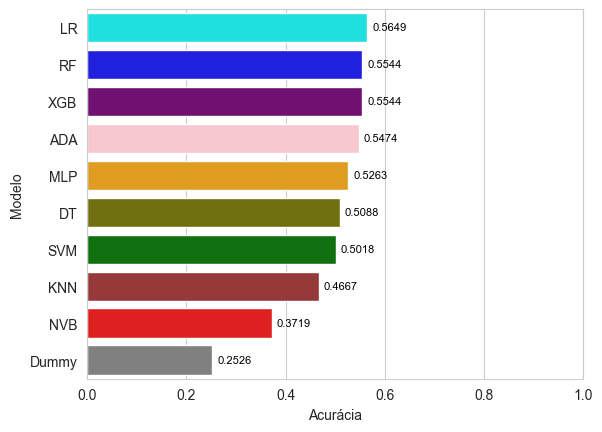

,Modelo,Acurácia
8,LR,0.564912
1,RF,0.554386
4,XGB,0.554386
6,ADA,0.547368
3,MLP,0.526316
9,DT,0.508772
2,SVM,0.501754
5,KNN,0.466667
7,NVB,0.371930
0,Dummy,0.252632


In [84]:
avalia_dif_modelos_cv(X_train5_re, y_train5_re, 5)

---------------------------------------------
model_name:  DummyClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.27      0.24        92
           1       0.25      0.15      0.18        96
           2       0.29      0.34      0.31        97

    accuracy                           0.25       285
   macro avg       0.25      0.25      0.25       285
weighted avg       0.25      0.25      0.25       285
---------------------------------------------
model_name:  RandomForestClassifier
Average Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.72        92
           1       0.74      0.81      0.77        96
           2       0.53      0.42      0.47        97

    accuracy                           0.66       285
   macro avg       0.65      0.66      0.65       285
weighted avg       0.65      0.66      0.65       285

--------------------

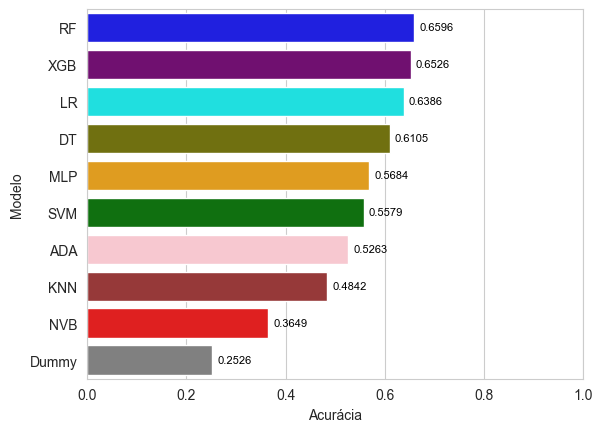

,Modelo,Acurácia
1,RF,0.659649
4,XGB,0.652632
8,LR,0.638596
9,DT,0.610526
3,MLP,0.568421
2,SVM,0.557895
6,ADA,0.526316
5,KNN,0.484211
7,NVB,0.364912
0,Dummy,0.252632


In [85]:
avalia_dif_modelos_cv(X_train6_re, y_train6_re, 5)

 ## Avaliando modelos com Under-Sampling e Cross Validation

In [86]:
# Chamando função para cada uma das bases
# Aplicando Random Forest no under-sampling com Cross Validation de 10 folds
# # 
# # perform_cross_validation(model, data1_re, target1_re, 5, True)
# # 
# # 

In [87]:
# perform_cross_validation(model, data2_re, target2_re, 5, True)


In [88]:
# perform_cross_validation(model, data3_re, target3_re, 5, True)

In [89]:
# perform_cross_validation(model, data4_re, target4_re, 5, True)

In [90]:
# modelMLP = MLPClassifier()
# perform_cross_validation(modelMLP, data5_re, target5_re, 5, True)

In [91]:
# perform_cross_validation(model, data6_re, target6_re, 5, True)

## Tunning dos hiperparâmetros

### Parametros para grid search

In [92]:
#Definindo parametros:
#Definir os modelos e os grids de parâmetros
models = {
    'Random Forest': RandomForestClassifier(n_jobs=n_cpus, random_state=13),
    'SVM': SVC(random_state=13),
    'MLP': MLPClassifier(random_state=13),
    'XGBoost': XGBClassifier(n_jobs=n_cpus, random_state=13),
    'KNN': KNeighborsClassifier(n_jobs=n_cpus),
    'ADA': AdaBoostClassifier(random_state=13),
    'NVB': GaussianNB(),
    'LR': LogisticRegression(random_state=13, n_jobs=n_cpus, max_iter=1000),
    'DT': DecisionTreeClassifier(random_state=13)
}

param_grids = [
    {
        'model': 'Random Forest',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [None, 5, 10, 15, 20, ],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_jobs': [n_cpus]
        }
    },
    {
        'model': 'SVM',
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto']
        }
    },
    {
        'model': 'MLP',
        'params': {
            'hidden_layer_sizes': [(10,), (50,), (100,), (150,), (200,)],
            'activation': ['logistic', 'tanh', 'relu'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
        }
    },
    {
        'model': 'XGBoost',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'max_depth': [3, 5, 7, 9, 11, 13, 15, ],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_jobs': [n_cpus]
        }
    }
    ,
    {
        'model': 'KNN',
        'params': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [5,10, 20, 30, 40, 50],
            'p': [1, 2, 3, 4, 5, 6]
        }
    }
    ,
    {
        'model': 'ADA',
        'params': {
            'n_estimators': [50, 100, 200, 300, 400, 500],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    }
    ,
    {
        'model': 'NVB',
        'params': {
            'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]
        }
    }
    ,
    {
        'model': 'LR',
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': [0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter': [50, 100, 200, 300, 400, 500],
            'n_jobs': [n_cpus]
        }
    }
]

### Tunning dos modelos com Random Under-Sampling

In [93]:
# Chamando função para cada uma das bases
print("========================== Data 1  =================================")
best_models1 = perform_model_tuning(models, param_grids, "data1", X_train1_re, y_train1_re, X_val1_re, y_val1_re)

========================== Data 1  =================================
Tuning do modelo Random Forest iniciado...
Tempo de execução: 493.66s | Modelo: Random Forest
Acurácia do modelo Random Forest: 0.4912
Tuning do modelo SVM iniciado...
Tempo de execução: 16.11s | Modelo: SVM
Acurácia do modelo SVM: 0.5439
Tuning do modelo MLP iniciado...
Tempo de execução: 101.26s | Modelo: MLP
Acurácia do modelo MLP: 0.5263
Tuning do modelo XGBoost iniciado...
Tempo de execução: 1429.98s | Modelo: XGBoost
Acurácia do modelo XGBoost: 0.5614
Tuning do modelo KNN iniciado...
Tempo de execução: 128.10s | Modelo: KNN
Acurácia do modelo KNN: 0.3684
Tuning do modelo ADA iniciado...
Tempo de execução: 43.02s | Modelo: ADA
Acurácia do modelo ADA: 0.5789
Tuning do modelo NVB iniciado...
Tempo de execução: 0.15s | Modelo: NVB
Acurácia do modelo NVB: 0.3333
Tuning do modelo LR iniciado...
Tempo de execução: 39.18s | Modelo: LR
Acurácia do modelo LR: 0.5088


Melhor modelo: ADA | Acurácia: 0.5789473684210527

Tem

In [ ]:
print("========================== Data 2  =================================")
best_models2 = perform_model_tuning(models, param_grids, "data2", X_train2_re, y_train2_re, X_val2_re, y_val2_re)

In [ ]:
print("========================== Data 3  =================================")
best_models3 = perform_model_tuning(models, param_grids, "data3", X_train3_re, y_train3_re, X_val3_re, y_val3_re)

In [ ]:
print("========================== Data 4  =================================")
best_models4 = perform_model_tuning(models, param_grids, "data4", X_train4_re, y_train4_re, X_val4_re, y_val4_re)

In [ ]:
print("========================== Data 5  =================================")
best_models5 = perform_model_tuning(models, param_grids, "data5", X_train5_re, y_train5_re, X_val5_re, y_val5_re)

In [ ]:
print("========================== Data 6  =================================")
best_models6 = perform_model_tuning(models, param_grids, "data6", X_train6_re, y_train6_re, X_val6_re, y_val6_re)

### Avaliando os modelos com os melhores parâmetros

In [ ]:
# Pìcle best_models 1 à 6
with open('best_models1.pkl', 'wb') as f:
    pickle.dump(best_models1, f)
with open('best_models2.pkl', 'wb') as f:
    pickle.dump(best_models2, f)
with open('best_models3.pkl', 'wb') as f:
    pickle.dump(best_models3, f)
with open('best_models4.pkl', 'wb') as f:
    pickle.dump(best_models4, f)
with open('best_models5.pkl', 'wb') as f:
    pickle.dump(best_models5, f)
with open('best_models6.pkl', 'wb') as f:
    pickle.dump(best_models6, f)

In [ ]:
# importando best_models1 a 3
print("========================== Data 1  =================================")
with open('best_models1.pkl', 'rb') as file:
    best_models1 = pickle.load(file)
    print(f'Best Models 1 = \n{best_models1}')
print("========================== Data 2  =================================")
with open('best_models2.pkl', 'rb') as file:
    best_models2 = pickle.load(file)
    print(f'Best Models 2 = \n{best_models2}')
print("========================== Data 3  =================================")
with open('best_models3.pkl', 'rb') as file:
    best_models3 = pickle.load(file)
    print(f'Best Models 3 = \n{best_models3}')
print("========================== Data 4  =================================")
with open('best_models4.pkl', 'rb') as file:
    best_models4 = pickle.load(file)
    print(f'Best Models 4 = \n{best_models4}')
print("========================== Data 5  =================================")
with open('best_models5.pkl', 'rb') as file:
    best_models5 = pickle.load(file)
    print(f'Best Models 5 = \n{best_models5}')
print("========================== Data 6  =================================")
with open('best_models6.pkl', 'rb') as file:
    best_models6 = pickle.load(file)
    print(f'Best Models 6 = \n{best_models6}')

### Selecionando o melhor modelo de cada base

In [ ]:
# Pegar o melhor modelo de cada base, usando max, para em seguida aplicar SBFS e SFFS com cross validation
#


# para cada um dos modelos
#best_model1 = max(best_models1, key=best_models1.get)
#modelo1 = best_models1['Random Forest']

In [18]:

#best_model2 = max(best_models2, key=best_models2.get)
modelo2 = best_models2['Random Forest']

# Ver todos os parametros do modelo
print(modelo2.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 16, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [19]:

#best_model3 = max(best_models3, key=best_models3.get)
modelo3 = best_models3['Random Forest']

# Ver todos os parametros do modelo
print(modelo3.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': 16, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [13]:

#best_model4 = max(best_models4, key=best_models4.get)
#modelo4 = best_models4['Random Forest']
# 
# modelo5 = best_models5['MLP']
# 
# modelo6 = best_models6['XGBoost']
#print(modelo1)
print(modelo2)
print(modelo3)
#print(modelo4)

RandomForestClassifier(max_depth=15, max_features='log2', min_samples_split=10,
                       n_jobs=16)
RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=16)


### Salvando os modelos

In [75]:
# Salvando modelo1 à 4 em pickle
#with open('modelo1.pkl', 'wb') as f:
#    pickle.dump(modelo1, f)
with open('modelo2.pkl', 'wb') as f:
   pickle.dump(modelo2, f)
with open('modelo3.pkl', 'wb') as f:
   pickle.dump(modelo3, f)
#with open('modelo4.pkl', 'wb') as f:
#    pickle.dump(modelo4, f)
# with open('modelo5.pkl', 'wb') as f:
#     pickle.dump(modelo5, f)
# with open('modelo6.pkl', 'wb') as f:
#     pickle.dump(modelo6, f)

### [Abrir modelos pickle]

In [6]:
# # Importando modelos pickl
# 
# with open('modelo1.pkl', 'rb') as file:
#     modelo1 = pickle.load(file)
#     print(f'Modelo1 = \n{modelo1}')
with open('modelo2.pkl', 'rb') as file:
    modelo2_ = pickle.load(file)
    print(f'Modelo2 = \n{modelo2}')
with open('modelo3.pkl', 'rb') as file:
    modelo3_ = pickle.load(file)
    print(f'Modelo3 = \n{modelo3}')
# with open('modelo4.pkl', 'rb') as file:
#     modelo4 = pickle.load(file)
#     print(f'Modelo4 = \n{modelo4}')
# with open('modelo5.pkl', 'rb') as file:
#     modelo5 = pickle.load(file)
#     print(f'Modelo5 = \n{modelo5}')
# with open('modelo6.pkl', 'rb') as file:
#     modelo6 = pickle.load(file)
#     print(f'Modelo6 = \n{modelo6}')


NameError: name 'modelo2' is not defined

### Avaliando os modelos com cross validation

In [ ]:
# Analisar cross validation para cada um dos modelos
#print("========================== Data 1  =================================")
#c1 = cross_val_score(modelo1, data1_re, target1_re , cv=5)
#print(c1)
#print(c1.mean())

#perform_cross_validation(modelo1, data1_re, target1_re, 5, True)

In [15]:
print("========================== Data 2  =================================")
c2 = cross_val_score(modelo2, data2_re, target2_re, cv=5)
print(c2)
print(c2.mean())

perform_cross_validation(modelo2, data2_re, target2_re, 5, True)

========================== Data 2  =================================
[0.68888889 0.71111111 0.79775281 0.6741573  0.76404494]
0.727191011235955
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        89
           2       0.00      0.00      0.00         0

    accuracy                           0.74        89
   macro avg       0.50      0.37      0.43        89
weighted avg       1.00      0.74      0.85        89

--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        60
           1       1.00      0.79      0.88        29
           2       0.00      0.00      0.00         0

    accuracy                           0.79        89
   macro avg       0.67      0.53      0.59        89
weighted avg       1.00      0.79      0.88        89

-------------------------------------

In [ ]:
#print("========================== Data 3  =================================")
#c3 = cross_val_score(modelo3, data3_re, target3_re, cv=5)
#print(c3)
#print(c3.mean())

#perform_cross_validation(modelo3, data3_re, target3_re, 5, True)


In [ ]:
#print("========================== Data 4  =================================")
#c4 = cross_val_score(modelo4, data4_re, target4_re, cv=5)
#print(c4)
#print(c4.mean())

#perform_cross_validation(modelo4, data4_re, target4_re, 5, True)

In [ ]:
print("========================== Data 5  =================================")
c5 = cross_val_score(modelo5, data5_re, target5_re, cv=5)
print(c5)
print(c5.mean())

perform_cross_validation(modelo5, data5_re, target5_re, 5, True)

In [ ]:
print("========================== Data 6  =================================")
c6 = cross_val_score(modelo6, data6_re, target6_re, cv=5)
print(c6)
print(c6.mean())

perform_cross_validation(modelo6, data6_re, target6_re, 5, True)

## Feature Selection

In [ ]:
updt_maxfeature(modelo1)
updt_maxfeature(modelo2)
updt_maxfeature(modelo3)
updt_maxfeature(modelo4)
updt_maxfeature(modelo5)
updt_maxfeature(modelo6)

### Aplicando SBFS e SFFS

#### Feature Selection nas bases com Random Under-Sampling

In [ ]:
# Chamando a função de feature selection para cada um dos "modelos*"
print("========================== Data 1  =================================")
slt_sbfs_features1, score1_sbfs = perform_feature_selection(data1, target1, modelo1, "data1", 'SBFS', 5)
slt_sffs_features1, score1_sffs = perform_feature_selection(data1, target1, modelo1, "data1", 'SFFS', 5)

In [17]:
print("========================== Data 2  =================================")
slt_sbfs_features2, score2_sbfs = perform_feature_selection(data2, target2, modelo2, "data2", 'SBFS', 5)
slt_sffs_features2, score2_sffs = perform_feature_selection(data2, target2, modelo2,"data2", 'SFFS', 5)

========================== Data 2  =================================


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:   10.6s finished

[2023-12-17 19:10:27] Features: 83/1 -- score: 0.784440065681445[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:   10.3s finished

[2023-12-17 19:10:37] Features: 82/1 -- score: 0.7821346469622332[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.4s finished

[2023-12-17 19:10:50] Features: 81/1 -- score: 0.783297208538588[Parallel(n_jobs=16)]: Using 

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
print("========================== Data 3  =================================")
slt_sbfs_features3, score3_sbfs = perform_feature_selection(data3, target3, modelo3, "data3", 'SBFS', 5)
slt_sffs_features3, score3_sffs = perform_feature_selection(data3, target3, modelo3, "data3", 'SFFS', 5)

In [ ]:
print("========================== Data 4  =================================")
slt_sbfs_features4, score4_sbfs = perform_feature_selection(data4, target4, modelo4,"data4", 'SBFS', 5)
slt_sffs_features4, score4_sffs = perform_feature_selection(data4, target4, modelo4, "data4", 'SFFS', 5)

In [ ]:
print("========================== Data 5  =================================")
slt_sbfs_features5, score5_sbfs = perform_feature_selection(data5, target5, modelo5, "data5", 'SBFS', 5)
slt_sffs_features5, score5_sffs = perform_feature_selection(data5, target5, modelo5, "data5", 'SFFS', 5)

In [ ]:
print("========================== Data 6  =================================")
slt_sbfs_features6, score6_sbfs = perform_feature_selection(data6, target6, modelo6, "data6", 'SBFS', 5)
slt_sffs_features6, score6_sffs = perform_feature_selection(data6, target6, modelo6, "data6", 'SFFS', 5)

### Salvando as features selecionadas

In [ ]:
# Criando um arquivo txt com a feature selecionadas
with open(f"results/SBFS_data1.txt", "w") as f:
    f.write(str(slt_sbfs_features1))
with open(f"results/SFFS_data1.txt", "w") as f:
    f.write(str(slt_sffs_features1))
with open(f"results/SBFS_data2.txt", "w") as f:
    f.write(str(slt_sbfs_features2))
with open(f"results/SFFS_data2.txt", "w") as f:
    f.write(str(slt_sffs_features2))
with open(f"results/SBFS_data3.txt", "w") as f:
    f.write(str(slt_sbfs_features3))
with open(f"results/SFFS_data3.txt", "w") as f:
    f.write(str(slt_sffs_features3))
with open(f"results/SBFS_data4.txt", "w") as f:
    f.write(str(slt_sbfs_features4))
with open(f"results/SFFS_data4.txt", "w") as f:
    f.write(str(slt_sffs_features4))
with open(f"results/SBFS_data5.txt", "w") as f:
    f.write(str(slt_sbfs_features5))
with open(f"results/SFFS_data5.txt", "w") as f:
    f.write(str(slt_sffs_features5))
with open(f"results/SBFS_data6.txt", "w") as f:
    f.write(str(slt_sbfs_features6))
with open(f"results/SFFS_data6.txt", "w") as f:
    f.write(str(slt_sffs_features6))

### [Abrir features selecionadas]

In [ ]:
def ler_arquivo_txt(nome_arquivo):
    with open(nome_arquivo, 'r') as arquivo:
        vetor_strings = []
        for linha in arquivo:
            valores = linha.strip().replace('(', '').replace(')', '').replace("'", '').split(', ')
            vetor_strings.append(valores)
    return vetor_strings


In [ ]:
# Lendo os arquivos txt com as features selecionadas
slt_sbfs_features1 = ler_arquivo_txt('results/SBFS_data1.txt')[0]
slt_sffs_features1 = ler_arquivo_txt('results/SFFS_data1.txt')[0]
slt_sbfs_features2 = ler_arquivo_txt('results/SBFS_data2.txt')[0]
slt_sffs_features2 = ler_arquivo_txt('results/SFFS_data2.txt')[0]
slt_sbfs_features3 = ler_arquivo_txt('results/SBFS_data3.txt')[0]
slt_sffs_features3 = ler_arquivo_txt('results/SFFS_data3.txt')[0]
slt_sbfs_features4 = ler_arquivo_txt('results/SBFS_data4.txt')[0]
slt_sffs_features4 = ler_arquivo_txt('results/SFFS_data4.txt')[0]
slt_sbfs_features5 = ler_arquivo_txt('results/SBFS_data5.txt')[0]
slt_sffs_features5 = ler_arquivo_txt('results/SFFS_data5.txt')[0]
slt_sbfs_features6 = ler_arquivo_txt('results/SBFS_data6.txt')[0]
slt_sffs_features6 = ler_arquivo_txt('results/SFFS_data6.txt')[0]

### Avaliando os modelos com as features selecionadas

In [ ]:
# Testando os modelos com as features selecionadas
print("========================== Data 1  - SBFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sbfs_features1], target1_re, 5, False)

print("========================== Data 1  - SFFS =================================")
perform_cross_validation(modelo1, data1_re.loc[:,slt_sffs_features1], target1_re, 5, False)

In [ ]:
print("========================== Data 2  - SBFS =================================")
perform_cross_validation(modelo2, data2_re.loc[:,slt_sbfs_features2], target2_re, 5, False)

print("========================== Data 2  - SFFS =================================")
perform_cross_validation(modelo2, data2_re.loc[:,slt_sffs_features2], target2_re, 5, False)

In [ ]:
print("========================== Data 3  - SBFS =================================")
perform_cross_validation(modelo3, data3_re.loc[:,slt_sbfs_features3], target3_re, 5, False)

print("========================== Data 3  - SFFS =================================")
perform_cross_validation(modelo3, data3_re.loc[:,slt_sffs_features3], target3_re, 5, False)

In [ ]:
print("========================== Data 4  - SBFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sbfs_features4], target4_re, 5, False)

print("========================== Data 4  - SFFS =================================")
perform_cross_validation(modelo4, data4_re.loc[:,slt_sffs_features4], target4_re, 5, False)

In [ ]:
print("========================== Data 5  - SBFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sbfs_features5], target5_re, 5, False)

print("========================== Data 5  - SFFS =================================")
perform_cross_validation(modelo5, data5_re.loc[:,slt_sffs_features5], target5_re, 5, False)

In [ ]:
print("========================== Data 6  - SBFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sbfs_features6], target6_re, 5, False)

print("========================== Data 6  - SFFS =================================")
perform_cross_validation(modelo6, data6_re.loc[:,slt_sffs_features6], target6_re, 5, False)

## Matriz de Confusão

In [ ]:


# Definindo as classes
classes = ["Baixo", "Médio", "Alto"]

# Sua matriz de confusão de três classes
conf_matrix = np.array([[20, 0, 2],
                        [0, 30, 1],
                        [12, 3, 27]])

# Calculando precisão, recall e f1 score para cada classe
precision = []
recall = []
f1 = []

for i in range(len(conf_matrix)):
    TP = conf_matrix[i][i]
    FP = sum(conf_matrix[r][i] for r in range(len(conf_matrix)) if r != i)
    FN = sum(conf_matrix[i][c] for c in range(len(conf_matrix)) if c != i)

    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))
    f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))

# Criando um DataFrame com os resultados
df = pd.DataFrame({'Classe': classes, 'Precisão': precision, 'Recall': recall, 'F1 Score': f1})

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.xlabel('Classe Prevista', size=12, fontweight='bold')
plt.ylabel('Classe Real', size=12, fontweight='bold')
plt.title('Matriz de Confusão - SBFS - DATA 2', size=14, fontweight='bold')
plt.savefig('confusion_matrix_sbfs_data2.png', dpi=300, transparent=True)
plt.show()

# Exibindo a tabela com os resultados
print("Tabela de Resultados:")
df


